<h1>Affine-Invariant Markov Chain Monte Carlo with <i>emcee</i></h1>

Today's lab session explores the python package <i>emcee</i> which provides an
implementation of the Goodman & Weare affine-invariant MCMC ensemble sampler.  We'll see how it allows us to sample the parameters of a posterior probability distribution function, without having to specify any step sizes.  We'll also look at how the default <i>emcee</i> "stretch move" fails on multi-modal distributions, and how to improve that.

We'll start out with our data set and model from last week -- we're fitting a linear model `y = b + m x`, where `y` are measured, `x` are assumed to be known (or measured with negligibly small errors), and we want to infer the distribution of `b` and `m` (in other words, put constraints on those parameters).


In [1]:
import pylab as plt
import numpy as np
import scipy.stats
import scipy.optimize

In [4]:
# Install the emcee & corner packages
!pip3 install emcee corner

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 29.1 MB/s  0:00:00 33.0 MB/s eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 15.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 15.5 MB/s  0:00:006.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 15.1 MB/s  0:00:006.2 MB/s eta 0:00:01
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13/13 [corner]37m━━━━━━ 11/13 [matplotlib]util]


In [2]:
import emcee
import corner

In [3]:
# Example data set from  arxiv:1008.4686, table 1 (https://arxiv.org/abs/1008.4686)
# You can also refer to that paper for more background, equations, etc.
alldata = np.array([[201,592,61],[244,401,25],[47 ,583,38],[287,402,15],[203,495,21],[58 ,173,15],[210,479,27],
                   [202,504,14],[198,510,30],[158,416,16],[165,393,14],[201,442,25],[157,317,52],[131,311,16],
                   [166,400,34],[160,337,31],[186,423,42],[125,334,26],[218,533,16],[146,344,22],]).astype(float)
# The first 5 data points are outliers; for the first part we'll just use the "good" data points
x    = alldata[5:,0]
y    = alldata[5:,1]
# this is the standard deviation (uncertainty) on the y measurements, also known as \sigma_i
yerr = alldata[5:,2]
# Note that x, y, and yerr are *vectors*

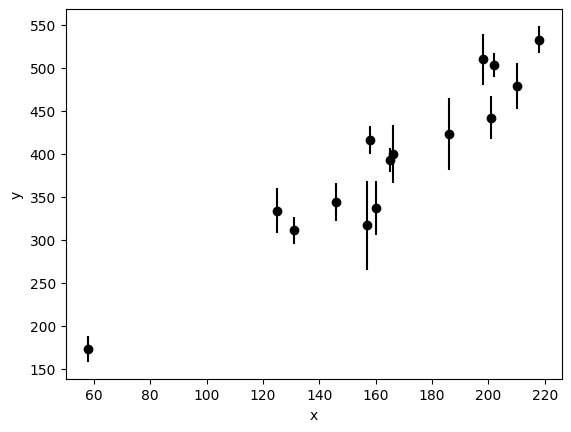

In [4]:
# To start, let's have a look at our data set.
plt.errorbar(x, y, yerr=yerr, fmt='o', color='k');
plt.xlabel('x'); plt.ylabel('y');

We'll re-use the log-likelihood function from last week.  For given parameters `b` and `m`, this makes <i>predictions</i> of the `y` values we should observe, and then computes the difference in "sigmas" of our real measurements from the predictions, and returns the sums of the log-likelihoods of drawing points with those numbers of sigmas from a Gaussian distribution.

In [5]:
def log_likelihood_one(params, x, y, yerr):
    '''This function computes the log-likelihood of a data set with coordinates
    (x_i,y_i) and Gaussian uncertainties on y_i of yerr_i (aka sigma_i)

    The model is a straight line, so the model's predicted y values are
        y_pred_i = b + m x_i.

    params = (b,m) are the parameters (scalars)
    x,y,yerr are arrays (aka vectors)

    Return value is a scalar log-likelihood.
    '''
    # unpack the parameters
    b,m = params
    # compute the vector y_pred, the model predictions for the y measurements
    y_pred = b + m * x
    # compute the log-likelihoods for the individual data points
    # (the quantity inside the sum in the text above)
    loglikes = np.log(1. / (np.sqrt(2. * np.pi) * yerr)) + -0.5*(y - y_pred)**2 / yerr**2
    # the log-likelihood for the whole vector of measurements is the sum of individual log-likelihoods
    loglike = np.sum(loglikes)
    return loglike

Just like last week, we'll also use an optimization procedure from `scipy` to find the maximum-likelihood value, and an estimate of the variance.  You don't need to worry about understanding this code, it's just to give us an answer to compare our results with!

Optimization terminated successfully.


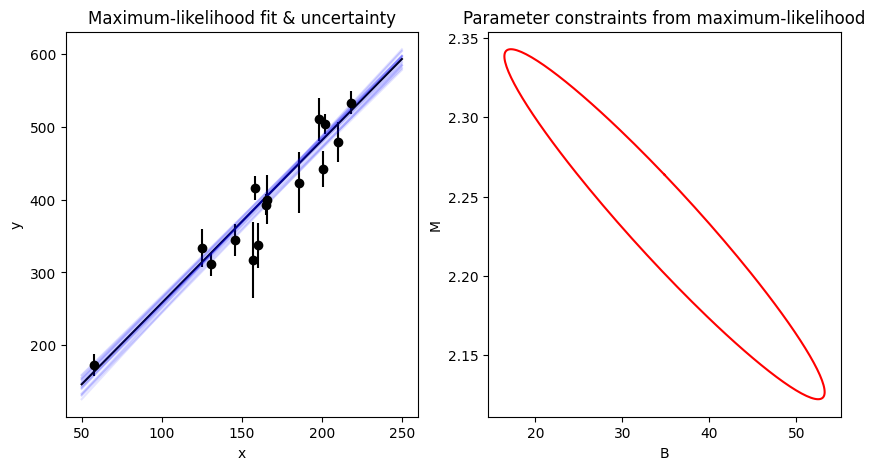

In [6]:
initial_params = [0., 0.]
# The "args" parameter here gets passed to the neg_ll_one function (after the parameters)
R = scipy.optimize.minimize(lambda bm: -log_likelihood_one(bm, x, y, yerr), initial_params)
print(R.message)
# These are the maximum-likelihood values from the optimizer
b_ml,m_ml = R.x
# This is an undercertainty ellipse in B,M space
U,s,V = np.linalg.svd(R.hess_inv)
S = np.dot(U, np.diag(np.sqrt(s)))
th = np.linspace(0,2.*np.pi,200)
xy = np.vstack((np.sin(th), np.cos(th)))
dbm = np.dot(S, xy).T
ellipse_b = R.x[0] + dbm[:,0]
ellipse_m = R.x[1] + dbm[:,1]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.errorbar(x, y, yerr=yerr, fmt='o', color='k');
plt.xlabel('x'); plt.ylabel('y');
BM = scipy.stats.multivariate_normal.rvs(mean=R.x, cov=R.hess_inv, size=20)
xx = np.linspace(50, 250, 50)
plt.plot(xx, b_ml + m_ml * xx, 'k-', label='Maximum-likelihood fit')
for b,m in BM:
    plt.plot(xx, b + xx*m, 'b-', alpha=0.1)
plt.title('Maximum-likelihood fit & uncertainty')

plt.subplot(1,2,2)
plt.plot(ellipse_b, ellipse_m, 'r-')
plt.xlabel('B')
plt.ylabel('M')
plt.title('Parameter constraints from maximum-likelihood');

In [7]:
R.hess_inv

array([[ 3.39401022e+02, -1.94946701e+00],
       [-1.94946701e+00,  1.21692366e-02]])

Now let's sample from this probability distribution using <i>emcee</i>.

If you did the lab exercises last week, we wrote our own MCMC function, and then tried to get good results out of it.  We found that we had to do quite a bit of work to find good step sizes for `b` and `m`, even ignoring the covariance between them.

With <i>emcee</i>, we don't need to set any step sizes -- which is really one of the big reasons that it caught on so well in the astronomy community!

In [9]:
# We're formally going to be Bayesians -- instead of using the log-likelihood, we're going to use the log-posterior
# distribution -- but we're going to use "flat" priors, so the difference is largely symbolic!
def log_posterior_one(params, x, y, yerr):
    loglike = log_likelihood_one(params, x, y, yerr)
    # Improper, flat priors on params!
    logprior = 0.
    return loglike + logprior

In [22]:
# We do need to tell emcee a bit about our problem, and choose one important parameter: the number of "walkers" to use!
# First: the dimensionality of our problem (2: b,m)
ndim = 2
# Now, the number of walkers.  Usually the advice is to set this pretty big
nwalkers = 100

# How many burn-in steps do we want to take?
nburn = 100
# How many samples do we want to take after burn-in?
nsteps = 2000

# Finally, we need to give the walkers some initial positions in B,M space.
# Here, we're just drawing uniform numbers in [0, 1).
# To make the plots below look better, we'll scale the "m"
# to lie in [1.9, 1.91)
p0 = np.random.rand(nwalkers, ndim)
p0[:,1] = 1.9 + p0[:,1] * 0.01

# We start by creating an *EnsembleSampler* object:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_one, args=[x, y, yerr])
# Let's start by running a "burn-in" phase for 100 steps.
r = sampler.run_mcmc(p0, nburn)
# Let's save that burn-in chain for later plotting!
burn_chain = sampler.get_chain()
sampler.reset()
# Now we'll take the results of the burn-in and do a "real" run (starting from the last coordinates from the burn-in phase).
sampler.run_mcmc(r.coords, nsteps)

print('Acceptance fraction: %.3f' % np.mean(sampler.acceptance_fraction))
# The "autocorrelation time" is a measure how many steps it takes until you get a sample that is approximately
# uncorrelated with the current sample.  Small values mean your sampler is working well!
print('Autocorrelation time: %.1f steps' % np.mean(sampler.get_autocorr_time()))

Acceptance fraction: 0.716
Autocorrelation time: 27.3 steps


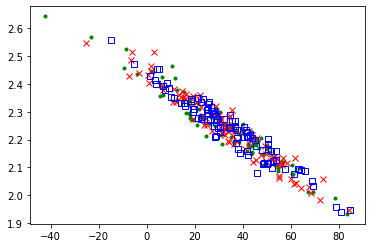

In [23]:
# Let's plot the positions of the walkers in last step of the chain, 50 steps back, and 100 steps back, in different colors.
ch = sampler.get_chain()
plt.plot(ch[-1,:,0], ch[-1,:,1], 'g.');
plt.plot(ch[-50,:,0], ch[-50,:,1], 'rx');
plt.plot(ch[-100,:,0], ch[-100,:,1], 's',mec='b',mfc='none');

Shape of chain: (2000, 100, 2)
Shape of the "flattened" chain: (200000, 2)


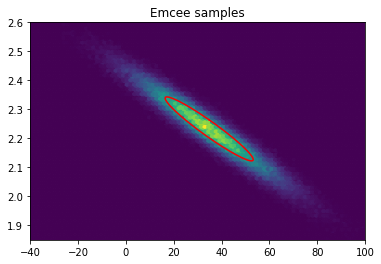

In [24]:
# Since emcee moves an "ensemble" of walker around the space, when it returns the chain, it is a three-dimensional
# array: (N_STEPS, N_WALKERS x N_DIMS):  (2000, 100, 2) for us.
print('Shape of chain:', sampler.get_chain().shape)

# Usually, you don't care about the difference between the "walkers" and "steps" dimensions -- you just want a big
# (N_samples x N_dim) array.  The "flat" chain is that:
print('Shape of the "flattened" chain:', sampler.get_chain(flat=True).shape)

ch = sampler.get_chain(flat=True)
plt.hexbin(ch[:,0], ch[:,1])
# Let's also plot the error ellipse we got from the optimizer!
plt.plot(ellipse_b, ellipse_m, 'r-')
plt.axis([-40, 100, 1.85, 2.6])
plt.title('Emcee samples');

We can display our results using the <tt>corner</tt> package.  This produces nice "corner plots" showing the projected (marginalized) distributions for each individual parameter, as well as all the pairs of covariances.

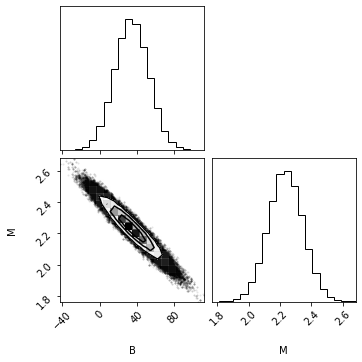

In [26]:
corner.corner(sampler.get_chain(flat=True), labels=['B','M']);

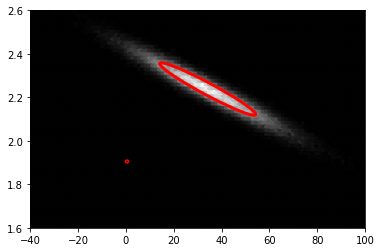

In [14]:
ext = [-40, 100, 1.6, 2.6]

ch = sampler.get_chain(flat=True)
plt.hexbin(ch[:,0], ch[:,1], cmap='gray', extent=ext)

def plot_ellipse(v1,v2):
    ax = plt.gca()
    cov = np.cov(v1, v2)
    s, v = np.linalg.eig(cov)
    s = np.sqrt(s)
    from matplotlib.patches import Ellipse
    ell = Ellipse(xy=(np.mean(v1), np.mean(v2)),
                  width=s[0]*2, height=s[1]*2,
                  angle=np.rad2deg(-np.arccos(v[0, 0])),
                  color='r', lw=3)
    ell.set_facecolor('none')
    ax.add_artist(ell)

# One fun way of seeing how the walkers move is to plot the covariance ellipses of the positions of the walkers at each step.
ch = burn_chain
(nsteps, nw, ndim) = ch.shape
# For example, here's how to plot the covariance ellipses of the first and last burn-in ellipses...
# first
i = 0
v1,v2 = ch[i, :, 0], ch[i, :, 1]
plot_ellipse(v1, v2)
# last
i = -1
v1,v2 = ch[i, :, 0], ch[i, :, 1]
plot_ellipse(v1, v2)

plt.axis(ext);


<b>Try plotting the ellipses from all the burn-in steps, or every Nth one, on whatever looks good to you.</b>

<h2>Affine Invariant Sampler vs Multi-modal distributions</h2>

Let's have a look at how the sampler breaks down when given a multi-modal distribution.

We'll cook up a multi-modal likelihood function made up of two Gaussians placed at different points in an `a`,`b`
plane that we'll sample in.

In [15]:
# A multi-modal distribution, with 2 parameters.
def log_like_multimodal(params):
    # unpack the parameters
    a,b = params

    # The distribution has two Gausians centered at these positions and with unit variance.
    # peak 1
    a1,b1 = 1., 5.
    # peak 2
    a2,b2 = 9., 5.
    # The fraction of mass in peak 1; peak2 will have 1-frac1
    frac1 = 0.5
    frac2 = 1 - frac1

    # I'm ignoring the 1/(sqrt(2pi) sigma) term of the Gaussian probability function 
    # because that is constant, and the sampler only cares about *relative*
    # changes in the log-likelihood.
    
    loglike1 = - 0.5 * ((a - a1)**2 + (b - b1)**2)
    loglike2 = - 0.5 * ((a - a2)**2 + (b - b2)**2)
    # the log-likelihood for the whole vector of measurements is the sum of individual weighted log-likelihoods
    loglike = np.sum(np.logaddexp(np.log(frac1) + loglike1, np.log(frac2) + loglike2))
    return loglike

In [16]:
# Let's sample from this multi-modal distribution.
nwalkers = 50
ndim = 2
nsteps = 1000
p0 = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like_multimodal)
# burn-in
r = sampler.run_mcmc(p0, nburn)
sampler.reset()
# Now we'll take the results of the burn-in and do a "real" run (starting from the last coordinates from the burn-in phase).
sampler.run_mcmc(r.coords, nsteps)

print('Acceptance fraction: %.3f' % np.mean(sampler.acceptance_fraction))
# The autocorrelation time function crashes because it is too large!
#print('Autocorrelation time: %.1f steps' % np.mean(sampler.get_autocorr_time()))

Acceptance fraction: 0.550


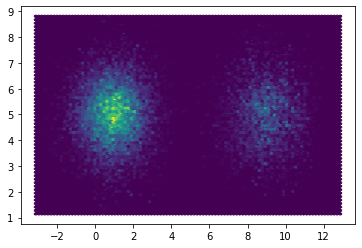

In [17]:
ch = sampler.get_chain(flat=True)
plt.hexbin(ch[:,0], ch[:,1]);

<b>Wow, what's going on here?</b>

It looks like the sampler is exploring both peaks, but not evenly!

<b>Experiment with this a bit. Try re-running it a few times -- do you always get the same split between the two peaks?</b>

<b>What if you run for more samples?</b>

<b>Try moving the initialization point -- does that change the balance between the two peaks?</b>

<b>
Try moving the centers of the peaks by editing the <tt>log_like_multimodal</tt> function above. How close together do they have to be for you to often get them looking balanced?</b>

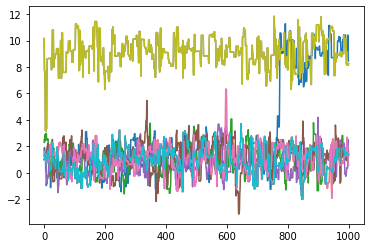

In [18]:
# One thing you can try is plotting the `x` positions of a few walkers...
ch =  sampler.get_chain()
for i in range(10):
    j = np.random.randint(nwalkers)
    plt.plot(ch[:, j, 0]);

You can see walkers jumping between the peaks.  But look at how rarely that happens -- only a few times in our 1000 steps.  That explains why the two peaks aren't evenly populated -- the jumps between the peaks are infrequent, so the effective number of samples is quite small!

<b>If you wanted to, you could try to <i>count</i> the number of times a walker jumps between modes, and see how that number changes as you, say, move the two modes closer together.

<h3>Using the Differential Evolution move to improve multi-modal performance</h3>

<tt>emcee</tt> includes other "moves" aside from its default "stretch" move.  One of these, the "DE" move, draws random samples and uses (a scaling of) their vector difference as a proposal.  This works well for multi-modal distributions, because any vector between the modes is probably an okay proposal that moves a new walker between modes.

In [28]:
# In emcee, we can use a combination of different move types by passing the "moves" argument to the sampler:

# The numbers after the move types are the relative fraction of those moves to use.
# The "DEMove" move has an optional parameter "gamma0" that sets the factor of the vector difference to propose --
# "None" means use the default.
moves = [
  (emcee.moves.DEMove(gamma0=None), 0.5),
  (emcee.moves.StretchMove(), 0.5),
  ]
  #(emcee.moves.DESnookerMove(), 0.2),

nburn = 100
nsteps = 2000
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like_multimodal,
                                moves=moves)
# burn-in
r = sampler.run_mcmc(p0, nburn)
sampler.reset()
# Now we'll take the results of the burn-in and do a "real" run (starting from the last coordinates from the burn-in phase).
sampler.run_mcmc(r.coords, nsteps)

print('Acceptance fraction: %.3f' % np.mean(sampler.acceptance_fraction))
print('Autocorrelation time: %.1f steps' % np.mean(sampler.get_autocorr_time()))

Acceptance fraction: 0.374
Autocorrelation time: 19.1 steps


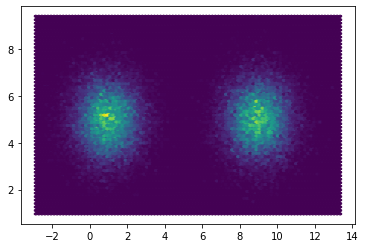

In [29]:
ch = sampler.get_chain(flat=True)
plt.hexbin(ch[:,0], ch[:,1]);

How does that look compared to the simple <i>emcee</i> version?

<b>Try changing the relative number of Stretch and DE moves.  Is there a mix that seems to work best?</b>

<b>The `DEMove` takes a parameter called "gamma0" (default value 2.38/sqrt(2 * N_ndim)) that says how much to scale the delta-vector by before proposing it as a move.  Does it work better to set this to 1.0, since that would let you jump exactly between the modes?  You can use the autocorrelation time (smaller is better) to measure how well it's working.</b>  Docs for the DEMove are here:
https://emcee.readthedocs.io/en/stable/user/moves/#ensemble-moves

